# Objectives
This notebook conducts a comprehensive credit card customer churn analysis through exploratory analysis and predictive modeling. The primary goals are to explore data distributions and churn patterns, build accurate churn prediction models, and extract actionable business insights for customer retention strategies.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Data Overview

In [4]:
df = pd.read_csv("/content/BankChurners.csv")
df.shape

(10127, 23)

In [5]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

In [7]:
print(df.nunique())

CLIENTNUM                                                                                                                             10127
Attrition_Flag                                                                                                                            2
Customer_Age                                                                                                                             45
Gender                                                                                                                                    2
Dependent_count                                                                                                                           6
Education_Level                                                                                                                           7
Marital_Status                                                                                                                            4
Income_Category     

In [8]:
# Removes unwanted fields (clientnumber and two Naive Bayes Classifier fields)
df = df.iloc[:, 1:-2]

Removed the unnecessary fields, client number and the two Naive Bayes Classifier fields

In [9]:
df.describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


# Exploratory Analysis

## Customer Demographics

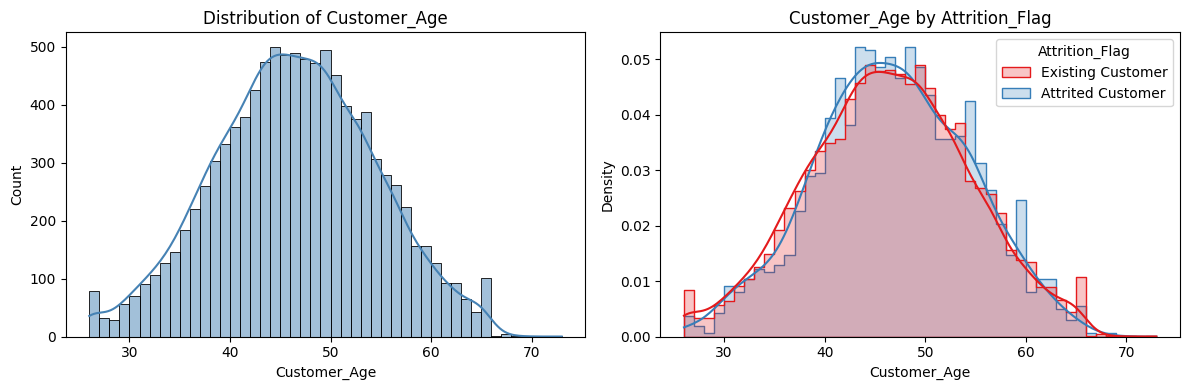

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Histogram
sns.histplot(df['Customer_Age'], kde=True, ax=axes[0], color="steelblue")
axes[0].set_title("Distribution of Customer_Age")
axes[0].set_xlabel('Customer_Age')
axes[0].set_ylabel("Count")

# Distribution by Attrition
sns.histplot(data=df, x='Customer_Age', hue="Attrition_Flag", kde=True, ax=axes[1],
            palette="Set1", element="step", stat="density", common_norm=False)
axes[1].set_title("Customer_Age by Attrition_Flag")
axes[1].set_xlabel('Customer_Age')
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.show()

In [11]:
print(df['Income_Category'].unique())

['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']


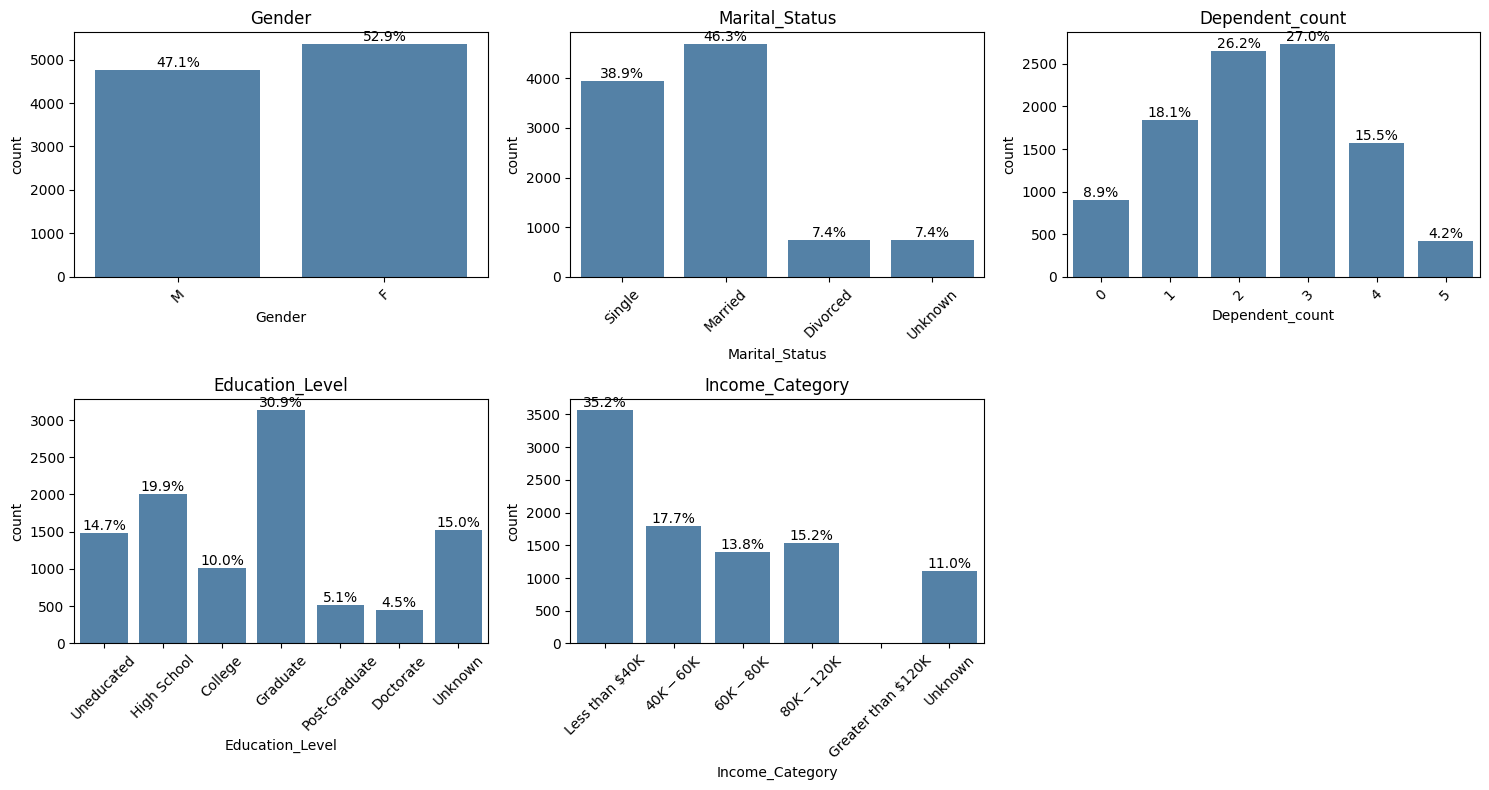

In [12]:
# Customer demographic categorical fields
demographic_cols = ['Gender', 'Marital_Status', 'Dependent_count', 'Education_Level', 'Income_Category']

demographic_orders = {
  'Gender': ['M', 'F'],
  'Dependent_count': [0, 1, 2, 3, 4, 5],
  'Education_Level': ['Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate', 'Unknown'],
  'Income_Category': ['Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', 'Greater than $120K', 'Unknown'],
  'Marital_Status': ['Single', 'Married', 'Divorced', 'Unknown']
}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(demographic_cols):
   sns.countplot(x=col, data=df, order=demographic_orders[col], ax=axes[i], color='steelblue')
   axes[i].set_title(col)
   axes[i].tick_params(axis='x', rotation=45)

   # Add percentage labels on bars
   total = len(df[col])
   for p in axes[i].patches:
       percentage = f'{100 * p.get_height() / total:.1f}%'
       axes[i].annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom', fontsize=10)

axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

- Majority of customers have a college level education
  - 31% of Customers hold graduate degrees making it the largest education segment
- 90% of customers have at least 1 dependent
- Majority of customers make less than 60k
    - No customers have an income higher than 120k

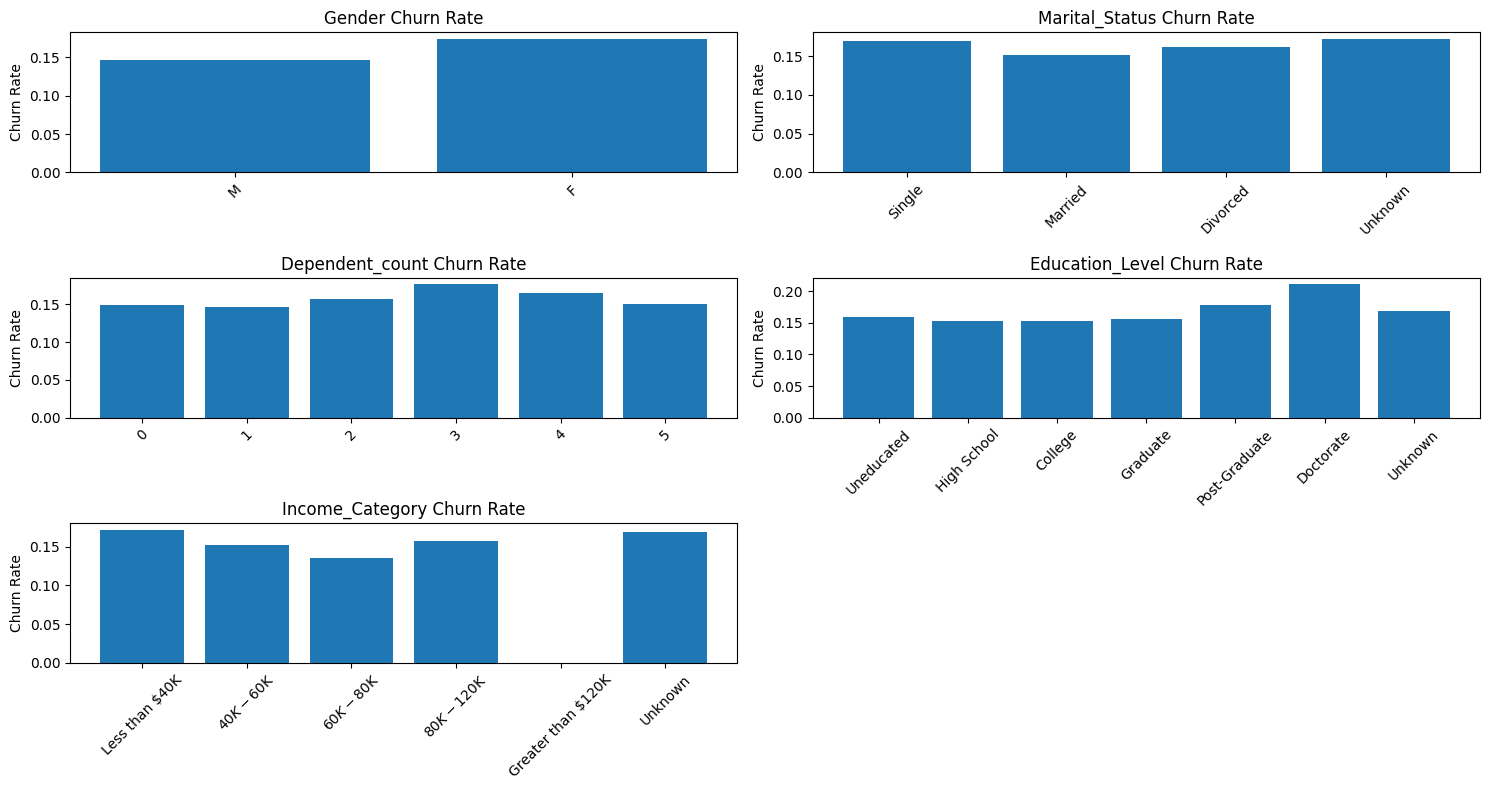

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(demographic_cols):
    # Churn rate per category
    churn_rate = df.groupby(col)['Attrition_Flag'].apply(lambda x: (x=='Attrited Customer').mean())

    if demographic_orders[col]:
        churn_rate = churn_rate.reindex(demographic_orders[col])

    axes[i].bar(churn_rate.index.astype(str), churn_rate.values)
    axes[i].set_title(f'{col} Churn Rate')
    axes[i].set_ylabel('Churn Rate')
    axes[i].tick_params(axis='x', rotation=45)

axes[-1].set_visible(False)

plt.tight_layout()
plt.show()


- Customer Age: Both churned and retained customers spread similarly
- Marital Status: No notable trends in churn rate based on Marital status or dependent count
- Education Level: Churn rate appears to increase at the higher education level while they remained balanced at the graduate level and below.
- Income category: Churn rate appears to decrease as income goes up although the trend stops at the 80k-120k range.

##  Bank Details

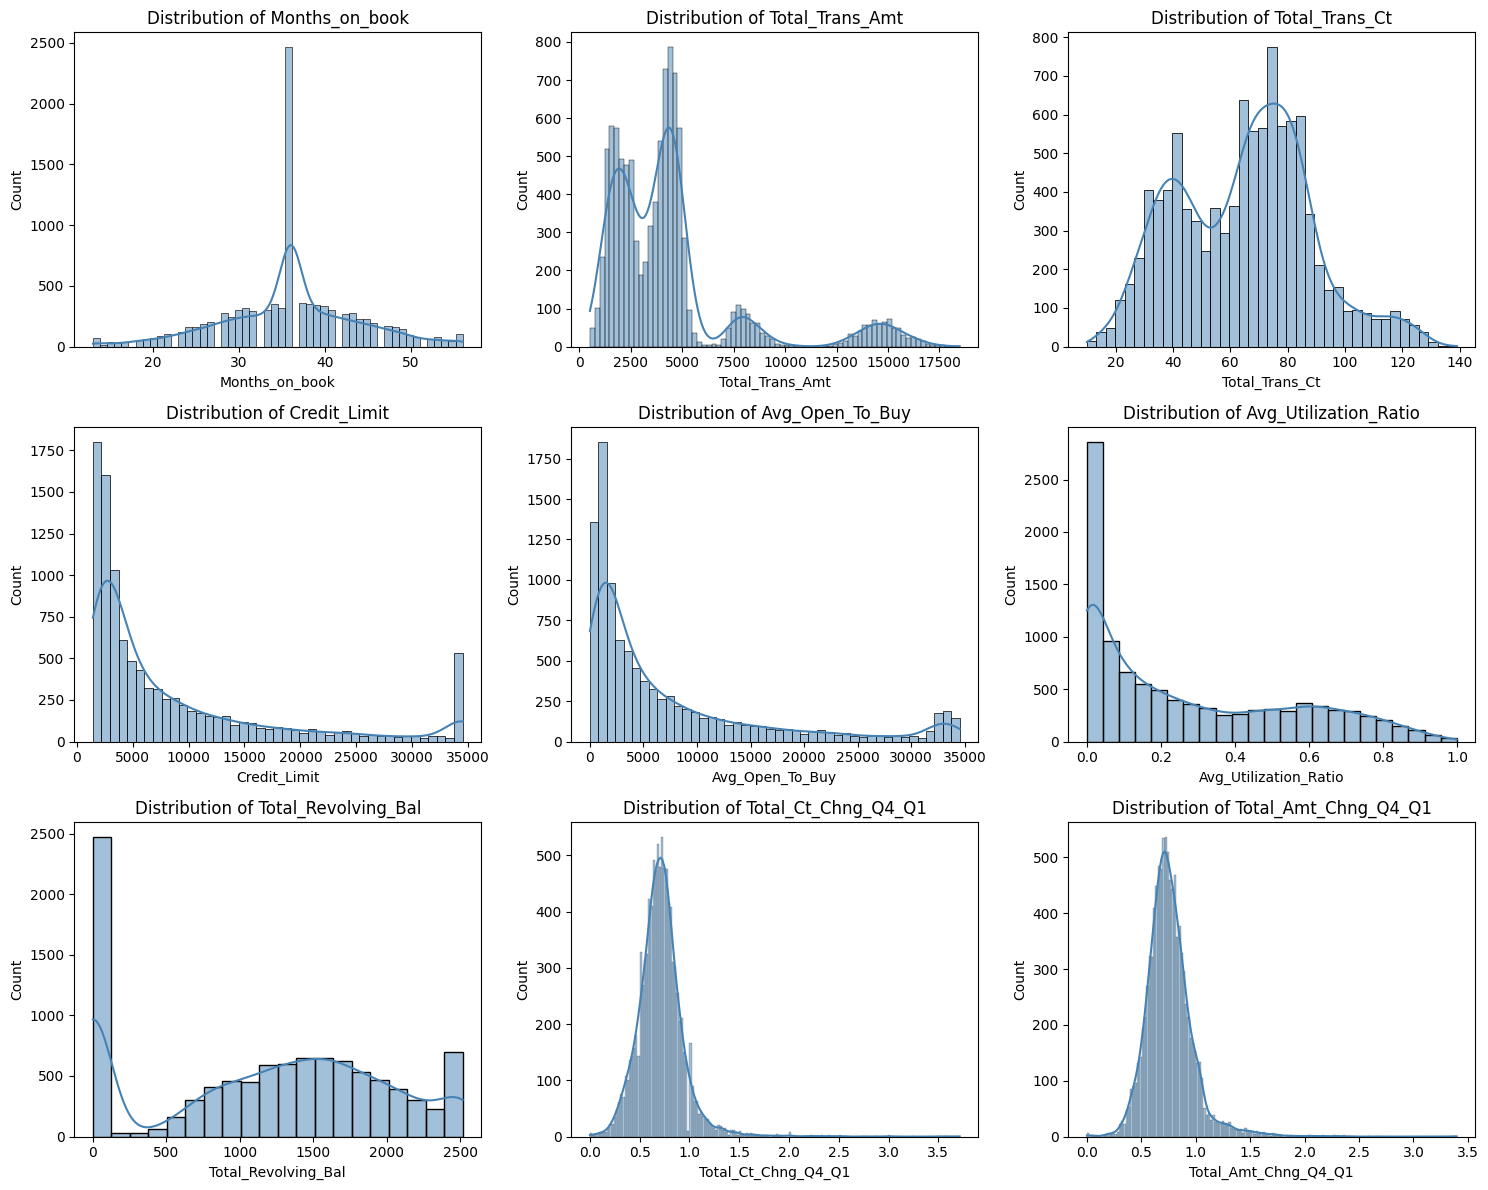

In [15]:
# Bank numerical fields
bank_numerical_cols = [
   'Months_on_book', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Credit_Limit', 'Avg_Open_To_Buy', 'Avg_Utilization_Ratio','Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1','Total_Amt_Chng_Q4_Q1',
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(bank_numerical_cols):
   sns.histplot(df[col], kde=True, ax=axes[i], color="steelblue")
   axes[i].set_title(f"Distribution of {col}")
   axes[i].set_xlabel(col)
   axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

Account Details
- Months on Book: Highly concentrated around 35-40 months suggesting most customers have similar account tenure with few very old or very new accounts
- Credit Limit: Right skewed with most customers having a credit limit under 10,000

Usage patterns
- Total Revolving Balance: Peaks near zero and $1500 indicating indicating there may be two distinct customer groups, those who pay off balances and those who carry debt.
- Average Open to Buy: Heavily concentrated near zero although many customers already have lower credit limits.
- Distribution of credit limit and average open to buy follow similar trends.
- Utilization ratio: right skewed indicating most customers pay off balances or use cards minimally.

The average open to buy closely resembles the Credit Limit distribution possibly indicating most customers pay off their balances. This is further supported bythe right skewed utilization ratio.

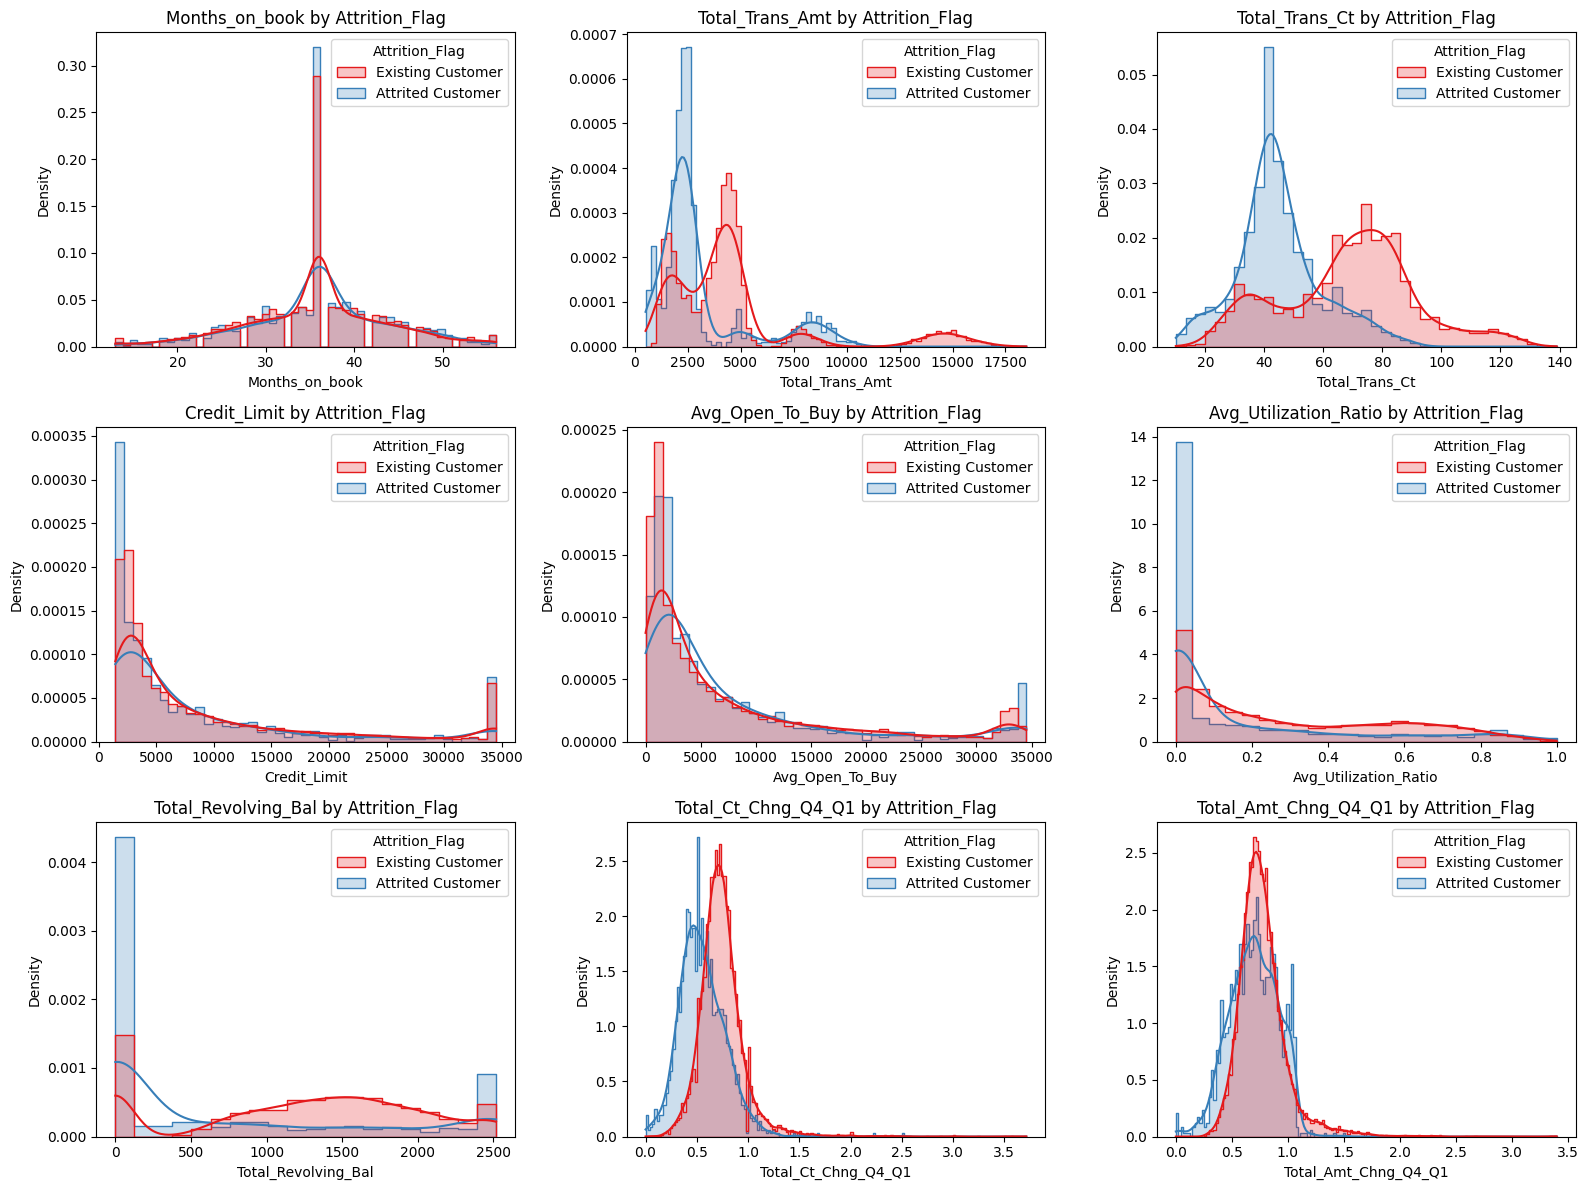

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(bank_numerical_cols):
    sns.histplot(data=df, x=col, hue="Attrition_Flag", kde=True, ax=axes[i],
                 palette="Set1", element="step", stat="density", common_norm=False)
    axes[i].set_title(f"{col} by Attrition_Flag")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")

plt.tight_layout()
plt.show()


- Transaction Count/Amount: Churned customers have lower transaction activity with the majority peaking in the 40-50 transaction range compared to the retained customers where many complete upwards of 60 transactions.
- Revolving Balance: Churned customers appear concentrated in the very low and very high balance customers ranges while retained customers appear to have more moderate balance amounts.


The strongest churn predictor appears to be low engagement metrics.

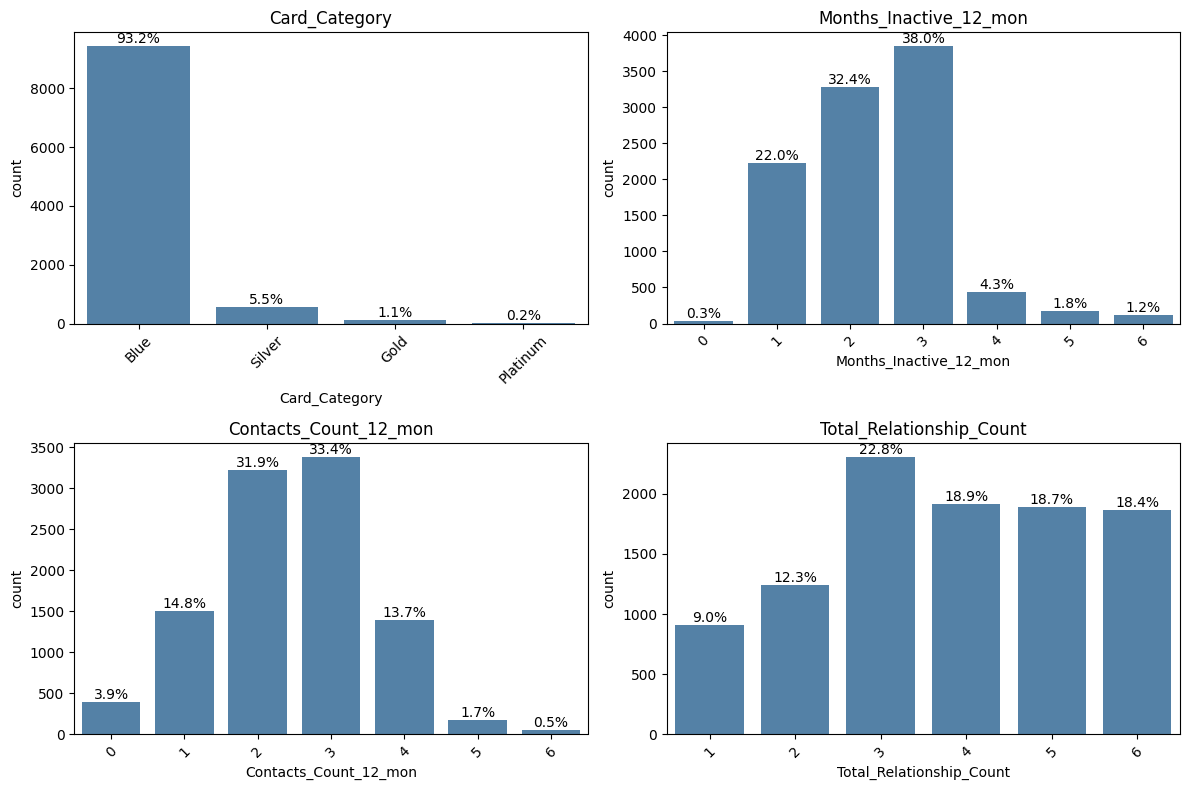

In [17]:
# Bank account categorical/discrete fields
bank_categorical_cols = ['Card_Category', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Relationship_Count']

bank_orders = {
 'Card_Category': ['Blue', 'Silver', 'Gold', 'Platinum'],
 'Months_Inactive_12_mon': None,
 'Contacts_Count_12_mon': None,
 'Total_Relationship_Count': None
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(bank_categorical_cols):
   sns.countplot(x=col, data=df, order=bank_orders[col], ax=axes[i], color='steelblue')
   axes[i].set_title(col)
   axes[i].tick_params(axis='x', rotation=45)

   # Add percentage labels on bars
   total = len(df[col])
   for p in axes[i].patches:
       percentage = f'{100 * p.get_height() / total:.1f}%'
       axes[i].annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

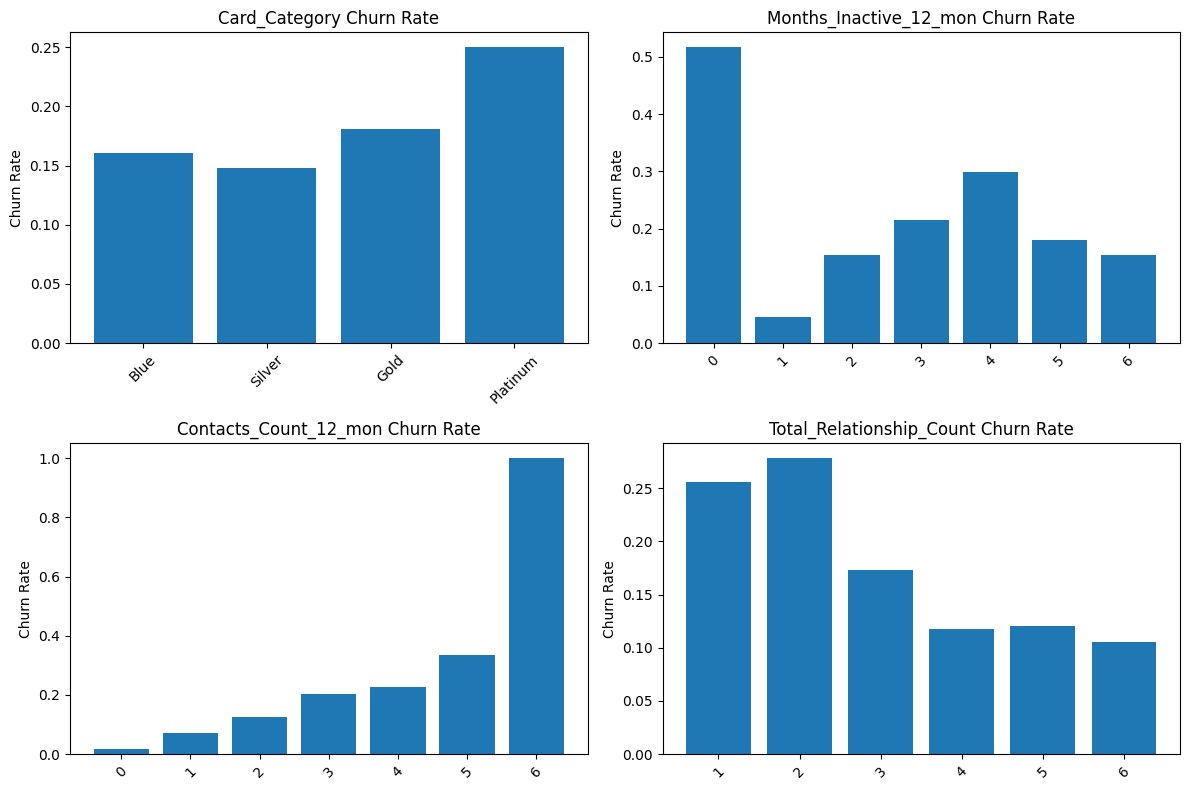

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(bank_categorical_cols):
   # Compute churn rate per category
   churn_rate = df.groupby(col)['Attrition_Flag'].apply(lambda x: (x=='Attrited Customer').mean())

   if bank_orders[col]:
       churn_rate = churn_rate.reindex(bank_orders[col])

   # Plot on the corresponding axis
   axes[i].bar(churn_rate.index.astype(str), churn_rate.values)
   axes[i].set_title(f'{col} Churn Rate')
   axes[i].set_ylabel('Churn Rate')
   axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

- Card category: Blue cards dominate the customer base at 93% but Platinum card holders have the highest churn rate
- Contact count: Churn rate increases with contact attempts, reaching nearly 100% churn rate at six contact attempts
- Total Relationship Count: Customers with fewer products are more susceptible to churning

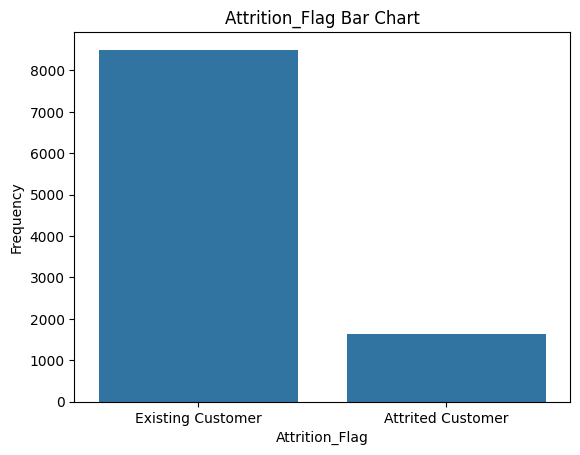

In [19]:
# Bar chart for Attrition_Flag
sns.countplot(x='Attrition_Flag', data=df)
plt.title('Attrition_Flag Bar Chart')
plt.xlabel('Attrition_Flag')
plt.ylabel('Frequency')
plt.show()


- Classes are not balanced. Likely won't use accuracy for performance metrics of the models and instead focus on precision, recall, F1 score and ROC AUC
- SMOTE will be used to balance the dataset prior to training

# Data Preprocessing
## Binary and One Hot-Encoding

In [20]:
# Binary encode Attrition Flag and Gender
df['Attrition_Flag'] = df['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})
df['Gender'] = df['Gender'].map({'F': 0, 'M': 1})

# One-hot encode categorical fields
categorical_cols = ['Education_Level', 'Income_Category', 'Marital_Status', 'Card_Category']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Removing unknown columns if they exist
unknown_cols = [col for col in df.columns if 'Unknown' in col]
df = df.drop(columns=unknown_cols, errors='ignore')


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Attrition_Flag                  10127 non-null  int64  
 1   Customer_Age                    10127 non-null  int64  
 2   Gender                          10127 non-null  int64  
 3   Dependent_count                 10127 non-null  int64  
 4   Months_on_book                  10127 non-null  int64  
 5   Total_Relationship_Count        10127 non-null  int64  
 6   Months_Inactive_12_mon          10127 non-null  int64  
 7   Contacts_Count_12_mon           10127 non-null  int64  
 8   Credit_Limit                    10127 non-null  float64
 9   Total_Revolving_Bal             10127 non-null  int64  
 10  Avg_Open_To_Buy                 10127 non-null  float64
 11  Total_Amt_Chng_Q4_Q1            10127 non-null  float64
 12  Total_Trans_Amt                 

In [22]:
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,...,Education_Level_Uneducated,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Marital_Status_Married,Marital_Status_Single,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0,45,1,3,39,5,1,3,12691.0,777,...,False,False,True,False,False,True,False,False,False,False
1,0,49,0,5,44,6,1,2,8256.0,864,...,False,False,False,False,True,False,True,False,False,False
2,0,51,1,3,36,4,1,0,3418.0,0,...,False,False,False,True,False,True,False,False,False,False
3,0,40,0,4,34,3,4,1,3313.0,2517,...,False,False,False,False,True,False,False,False,False,False
4,0,40,1,3,21,5,1,0,4716.0,0,...,True,False,True,False,False,True,False,False,False,False


### Correlation Analysis

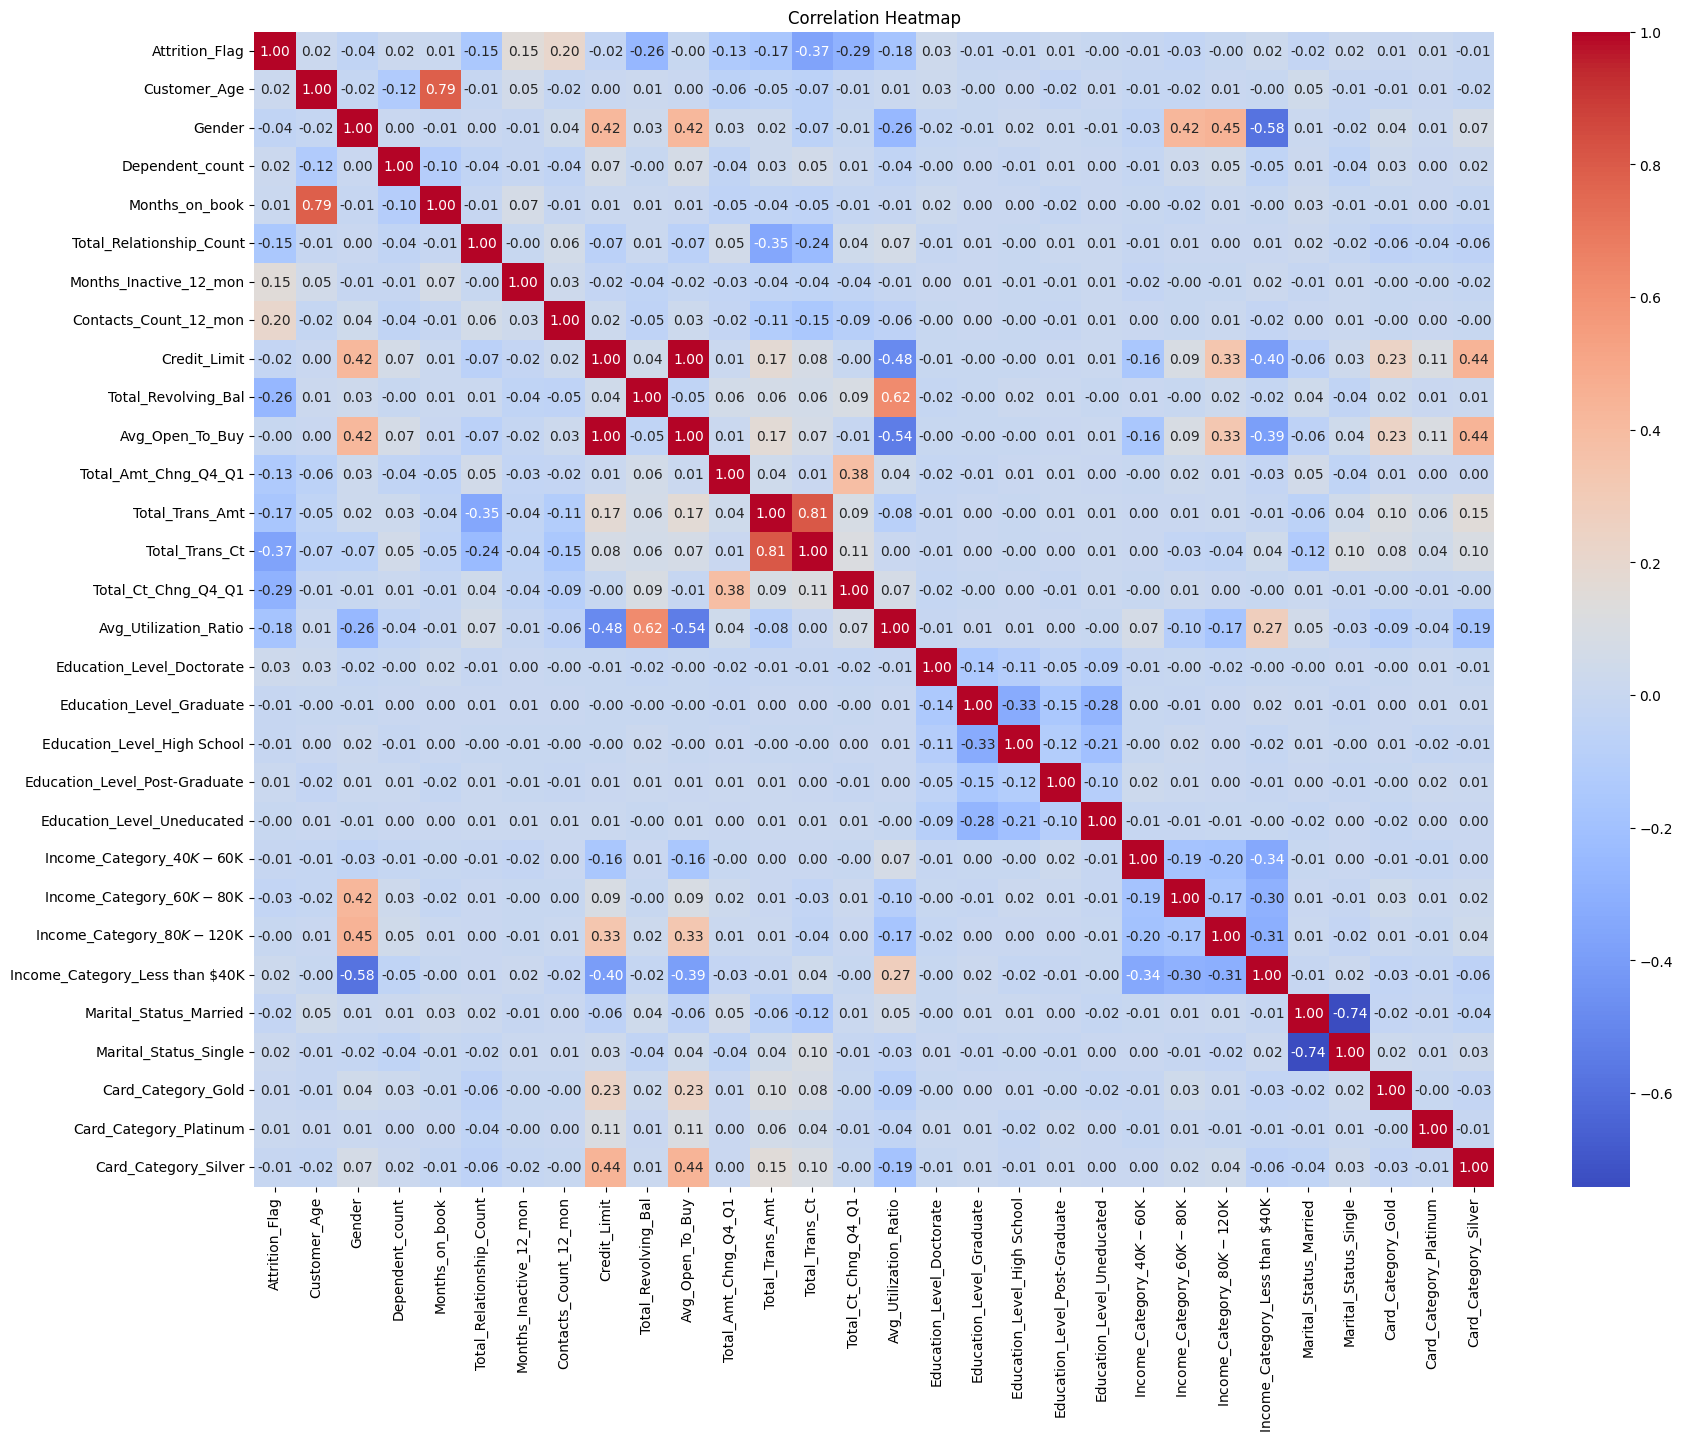

In [23]:
# Correlation Analysis
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


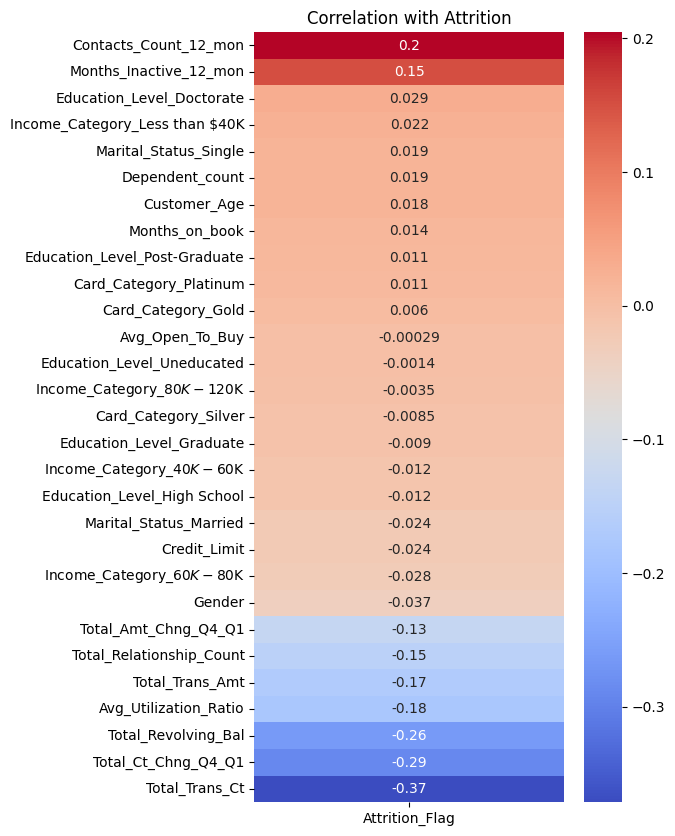

In [24]:
# Correlation with target variable Attrition
correlation = df.corr()
correlation_attrition = correlation['Attrition_Flag'].sort_values(ascending=False)
correlation_attrition = correlation_attrition.drop('Attrition_Flag')

plt.figure(figsize=(5, 10))
sns.heatmap(correlation_attrition.to_frame(), annot=True, cmap='coolwarm')
plt.title('Correlation with Attrition')
plt.show()



## SMOTE
Implemented to balance the data and applied only to the training split of each fold to prevent data leakage and allow the validation set to reflect the real-world imbalance.


In [27]:
models = {
    "RandomForestClassifier": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', RandomForestClassifier(random_state=42))
    ]),
    "LogisticRegression": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    "DecisionTreeClassifier": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', DecisionTreeClassifier(random_state=42))
    ]),
}

In [28]:
# Train Test Split
X = df.drop('Attrition_Flag', axis=1)
y = df['Attrition_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Model Training and Evaluation

## Stratified K-Fold Cross Validation
Implemented to ensures each fold maintains the original churn ratio.

In [29]:
# Defining scoring metrics
scoring = ['roc_auc', 'precision', 'recall', 'f1']

cv_results = {}
for name, model in models.items():
    print(f"\n{name} Results:")

    for score in scoring:
        cv_scores = cross_val_score(
            model, X_train, y_train,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring=score
        )
        cv_results[f"{name}_{score}"] = cv_scores
        print(f"  {score}: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")


RandomForestClassifier Results:
  roc_auc: 0.987 (+/- 0.004)
  precision: 0.867 (+/- 0.037)
  recall: 0.874 (+/- 0.042)
  f1: 0.870 (+/- 0.029)

LogisticRegression Results:
  roc_auc: 0.900 (+/- 0.013)
  precision: 0.587 (+/- 0.035)
  recall: 0.687 (+/- 0.030)
  f1: 0.633 (+/- 0.028)

DecisionTreeClassifier Results:
  roc_auc: 0.887 (+/- 0.020)
  precision: 0.751 (+/- 0.044)
  recall: 0.826 (+/- 0.052)
  f1: 0.787 (+/- 0.017)


The tree-based models appear to have the bes performance with RandomForest having the highest AUC and the lowest variance

## Hyperparamter Tuning

In [30]:
# Selecting mest model
main_metric = "roc_auc"
best_model_name = max(models.keys(), key=lambda name: cv_results[f"{name}_{main_metric}"].mean())
best_model = models[best_model_name]
best_model_name

'RandomForestClassifier'

In [32]:
# Setting paramters to test
param_grid = {
    "RandomForestClassifier": {
        'model__n_estimators': [100, 200], # Correct
        'model__max_depth': [3, 6, 9, None], # Correct (None is often included)
        'model__min_samples_split': [2, 5, 10], # RandomForest-specific
        'model__min_samples_leaf': [1, 2, 4], # RandomForest-specific
        # Remove 'model__learning_rate' and 'model__scale_pos_weight'
    }
}

grid_search = GridSearchCV(
    best_model,
    param_grid[best_model_name],
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_tuned_model = grid_search.best_estimator_


print("Best parameters:", grid_search.best_params_)
print(f"Best CV score: {grid_search.best_score_:.3f}")

Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best CV score: 0.987


No change in ROC score.

In [33]:
# Predictions
y_pred_proba = best_tuned_model.predict_proba(X_test)[:, 1]
y_pred = best_tuned_model.predict(X_test)

test_auc = roc_auc_score(y_test, y_pred_proba)
test_pr_auc = average_precision_score(y_test, y_pred_proba)

print(f"ROC AUC: {test_auc:.3f}")
print(f"PR AUC:  {test_pr_auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


ROC AUC: 0.984
PR AUC:  0.933

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1701
           1       0.85      0.84      0.85       325

    accuracy                           0.95      2026
   macro avg       0.91      0.91      0.91      2026
weighted avg       0.95      0.95      0.95      2026

Confusion Matrix:
[[1654   47]
 [  51  274]]


## Threshold Analysis
Business can decide which error is more costly and set thresholds accordingly.
Lower threshold results in more churn predictions, catching more real churners but also making more false alarms.

In [34]:
# Testing thresholds
for threshold in [0.3, 0.5, 0.7]:
    y_pred_custom = (y_pred_proba >= threshold).astype(int)
    print(f"\n Threshold {threshold}:")
    print(classification_report(y_test, y_pred_custom))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_custom))


 Threshold 0.3:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1701
           1       0.72      0.95      0.82       325

    accuracy                           0.93      2026
   macro avg       0.85      0.94      0.89      2026
weighted avg       0.95      0.93      0.94      2026

Confusion Matrix:
[[1578  123]
 [  16  309]]

 Threshold 0.5:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1701
           1       0.85      0.85      0.85       325

    accuracy                           0.95      2026
   macro avg       0.91      0.91      0.91      2026
weighted avg       0.95      0.95      0.95      2026

Confusion Matrix:
[[1652   49]
 [  50  275]]

 Threshold 0.7:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1701
           1       0.95      0.69      0.80       325

    accuracy                           0.

(Selection of thresholds depends on the business objectives)
- All thresholds appear to perform well
- F1 scores remain high across all thresholds (.88-.89)

## Feature Importance

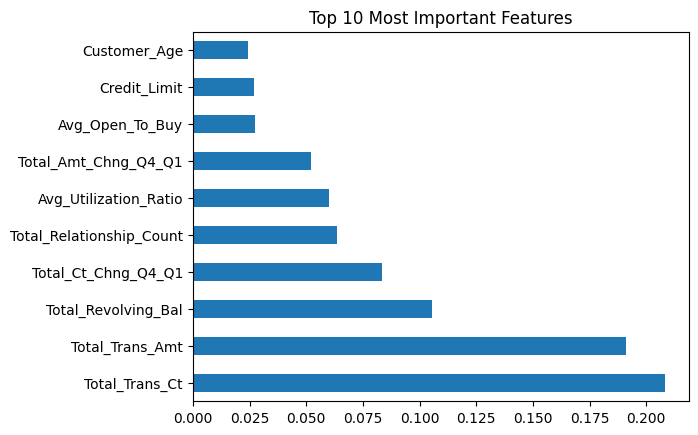

In [35]:
importances = best_tuned_model.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=X.columns)
top_10 = feat_imp.nlargest(10)
top_10.plot(kind='barh')
plt.title('Top 10 Most Important Features')
plt.show()

- Total transaction count is by far the most important feature for the model.
- In terms of customer demographic features, marital status and gender appear to have been useful in predicting churn although not as impactful as the account details and usage patterns.




# Conclusion
The exploratory analysis revealed that churned customers typically had significantly lower engagement metrics compared to retained customers, and these features appeared to be more important than customer demographics. This was further supported through predictive modeling, where transaction activity dominated in feature importance, followed by relationship count and revolving balance. These insights can help create targeted retention strategies by engaging low-activity customers and creating incentives for them to hold more products.